# Does harassment have a chilling effect on participation in Wikipedia?

## Study Plan

#### Establish correlation

Short term effects:

1. Take pairs of consecutive months. Regress 1{participation in month t2 is lower than in t1} on 1{ user experienced at least one attack in month t1}. Consider only taking one sample per user. Interpret coefficient.

2. Regress count(edits in t2) on count(edits t1), count(attacks in t1). Consider only taking one sample per user. Interprest coefficient. Consider poisson regression.

3. Add interaction terms: gender, topics, newness. Interpret interaction coefficients.

4. Limit data to new users, who made no personal attacks before they were attacked

5. Compare short term effects between new and experienced users

6. compare effect across namespaces. Could be that you see increased particiapation in talk and decrease in main

7. See if just participating in toxic discussion pages /articles makes you more likely to leave,  even if you don't recieve attacks on your talk page. As measures, consider edits to controversial topics/articles
https://en.wikipedia.org/wiki/Wikipedia:List_of_controversial_issues
https://en.wikipedia.org/wiki/Category:Wikipedia_controversial_topics
or ranking pages by proportion and volume of toxic comments




Long term effects (WIP)

1. LSTM on count(edits in month t), count(attacks month t), count(attack in t1-t0). Start at month the user registered. Train on balance of users who have and who have not experienced harassment. Compare accuraccy on hold out of users broken down by whether they set have been attacked at least once, with and without attack features.  


2. LSTM on inter-edit time interval. To measure impact: add random attacks to non-attacked users and see if inter edit time predictions increase?

#### Establish causation (WIP)

## Code

In [1]:
% matplotlib inline
import pandas as pd
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as sm

### Load Data

In [2]:
# load scord diffs for 2015
df_annotated = pd.read_csv("../../data/figshare/model_annotated_comments_2015.tsv", "\t")
del df_annotated['comment']
del df_annotated['raw_comment']
df_annotated['timestamp'] = pd.to_datetime(df_annotated['timestamp'])

In [3]:
# load edits per day for 2015
df_edits = pd.read_csv("../../data/retention/daily_edit_counts.tsv", "\t")
df_edits['timestamp'] = pd.to_datetime(df_edits['day'].apply(lambda x: str(x)))

In [4]:
# registration times of editors who made and edit in 2015
df_registration = pd.read_csv("../../data/retention/user_registration.tsv", "\t")
df_registration = df_registration.query("user_registration != 'null'")
ts = df_registration['user_registration'].apply(lambda x: str(x)[:8])
df_registration['user_registration'] = pd.to_datetime(ts, format = '%Y%m%d')

In [5]:
# genders
df_gender = pd.read_csv("../../data/genders.tsv", "\t")

In [6]:
# create df of consolidated user level features
df_user = df_edits.drop_duplicates(subset = 'user_text')[['user_text']]
df_user = df_user.merge(df_gender, on = 'user_text', how = "left")[['user_text', 'gender']]
df_user['gender'] = df_user['gender'].fillna('unknown')
df_user = df_user.merge(df_registration, on = 'user_text', how = "inner")[['user_text', 'gender', 'user_registration']]

### Visualizations

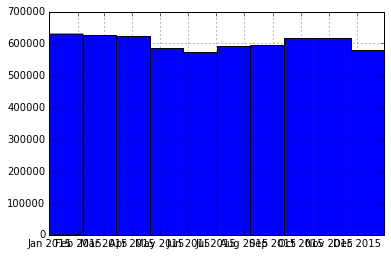

In [7]:
# hist of edits in 2015 by month
df_edits['timestamp'].hist()

Edit counts appear fairly uniform across months

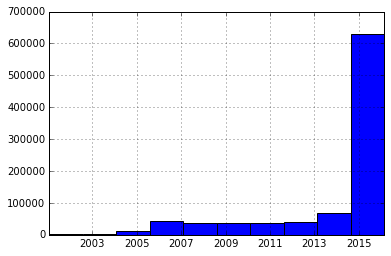

In [8]:
# hist of user registration times of editors who made at least one edit in 2015
df_user['user_registration'].hist()

Most editors who made an edit in 2015 are newcomers!

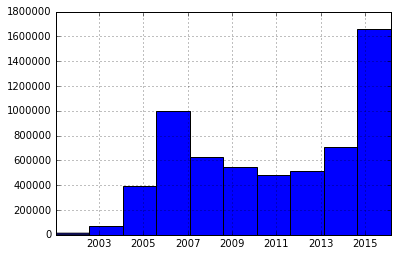

In [9]:
# hist of edits in 2015 by month editor registered
df_edits.merge(df_user, on = 'user_text')['user_registration'].hist()

Wow, I did not expect that so many edits come from new users!

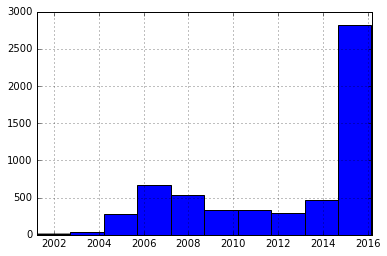

In [10]:
# attacks made by registration date
df_annotated.query("attack_score > 0.5").merge(df_user, on = 'user_text')['user_registration'].hist()

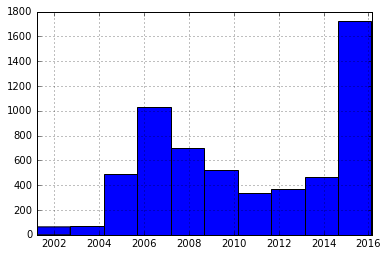

In [11]:
# attacks received by registration date
df_annotated.query("attack_score > 0.5 and ns == 'user'").merge(df_user, left_on = 'page_title', right_on = 'user_text')['user_registration'].hist()

In [12]:
df_user['gender'].value_counts()

unknown    854446
male        45597
female       5421
Name: gender, dtype: int64

### Reformat Data

In [13]:
# map data frames into dictionaries keyed by user
def gb_to_dict(gb):
    return { i:k for i,k in gb}

df_annotated_user_text_groups = gb_to_dict(df_annotated.groupby("user_text"))
df_annotated_page_title_groups =  gb_to_dict(df_annotated.query("ns == 'user'").groupby("page_title"))
df_edits_groups =  gb_to_dict(df_edits.groupby("user_text"))
df_user_groups =  gb_to_dict(df_user.groupby("user_text"))

In [14]:
# collect User objects 
class User():
    def __init__(self, user_text, df_annotated_user_text_groups, df_annotated_page_title_groups, df_edits_groups, df_user_groups):
        self.user_text = user_text
        self.df_activity =  df_edits_groups.get(user_text, None)
        self.df_comments_made =  df_annotated_user_text_groups.get(user_text, None)
        self.df_comments_received = df_annotated_page_title_groups.get(user_text, None)
        self.gender = df_user_groups[user_text]['gender'].iloc[0]
        self.user_registration = df_user_groups[user_text]['user_registration'].iloc[0]

### RQ1: Does being harassed in the first month make newcomers less likely to make edits in the second month?

#### Select newcomer sample

In [15]:
# select subset of users to regress on, only consider new comers who registered between Jan and Oct
n = 400000
user_texts = df_user.query("user_registration >= '2015-01-01'")
user_texts = df_user.query("user_registration <= '2015-10-01'")
print("Total Users: ", user_texts.shape[0])
user_texts = user_texts.sample(n)['user_text']


user_objects = [User( user_text,
                      df_annotated_user_text_groups,
                      df_annotated_page_title_groups,
                      df_edits_groups,
                      df_user_groups) 
                for user_text in user_texts]

len(user_objects)

Total Users:  768886


400000

#### Feature extraction

In [16]:
def select_timespan(user,  activity, t):
    start = user.user_registration + relativedelta(months=(t-1))
    stop = user.user_registration + relativedelta(months= t)
    activity = activity[activity['timestamp'] < stop]
    activity = activity[activity['timestamp'] >= start]
    return activity

def count_edits(user, t):
    activity = user.df_activity
    activity = select_timespan(user,  activity, t)
    return activity['n'].sum()

def count_days_active(user, t):
    activity = user.df_activity
    activity = select_timespan(user,  activity, t)
    return len(activity.timestamp.unique())

def count_score_received_above_threshold(user, score, threshold, t):
    if user.df_comments_received is None:
        return 0
    
    comments = user.df_comments_received
    comments = select_timespan(user,  comments, t)
    return (comments[score] > threshold).sum()

def count_score_made_above_threshold(user, score, threshold, t):
    if user.df_comments_made is None:
        return 0
    
    comments = user.df_comments_made
    comments = select_timespan(user,  comments, t)
    return (comments[score] > threshold).sum()

def is_female(u):
    return u.gender == 'female'

def is_male(u):
    return u.gender == 'male'

threshold  = 0.425
df_reg = pd.DataFrame({
        'is_female' : [is_female(u) for u in user_objects],
        'is_male' : [is_male(u) for u in user_objects],
        't1_num_edits' : [count_edits(u, 1) for u in user_objects],
        't2_num_edits' : [count_edits(u, 2) for u in user_objects],
        't1_num_days_active' : [count_days_active(u, 1) for u in user_objects],
        't2_num_days_active' : [count_days_active(u, 2) for u in user_objects],
        't1_num_attacks_received' : [count_score_received_above_threshold(u, 'attack_score',  threshold, 1) for u in user_objects],
        't1_num_aggression_received' : [count_score_received_above_threshold(u,  'aggression_score',  threshold, 1) for u in user_objects],
        't1_num_attacks_made' : [count_score_made_above_threshold(u, 'attack_score',  threshold, 1) for u in user_objects],
        't1_num_aggresssion_made': [count_score_made_above_threshold(u,  'aggression_score',  threshold, 1) for u in user_objects],
    })

df_reg.shape

(400000, 10)

In [17]:
df_reg['t1_active'] = df_reg['t1_num_edits'] > 0
df_reg['t2_active'] = df_reg['t2_num_edits'] > 0
df_reg['t1_harassment_received'] = (df_reg['t1_num_attacks_received'] > 0) | (df_reg['t1_num_aggression_received'] > 0)
df_reg['t1_harassment_made'] = (df_reg['t1_num_attacks_made'] > 0) | (df_reg['t1_num_aggresssion_made'] > 0)
df_reg.shape

(400000, 14)

In [18]:
df_reg = df_reg.astype(int)

In [19]:
# only consider friendly users who made at least one edit in the first month afer registering
df_reg2 = df_reg.query('t1_active ==1 and t1_harassment_made == 0')

In [20]:
# remove outliers
df_reg3 = df_reg2.query('t1_num_edits < 200 and t2_num_edits < 200')

#### Modeling

In [21]:
df_reg.describe()

,is_female,is_male,t1_num_aggression_received,t1_num_aggresssion_made,t1_num_attacks_made,t1_num_attacks_received,t1_num_days_active,t1_num_edits,t2_num_days_active,t2_num_edits,t1_active,t2_active,t1_harassment_received,t1_harassment_made
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.006553,0.057482,0.001980,0.003717,0.003005,0.001515,0.850017,4.612360,0.133920,1.607838,0.576497,0.050888,0.001512,0.002703
std,0.080682,0.232763,0.075539,0.097410,0.084059,0.059814,1.405262,865.684679,0.978965,428.646973,0.494114,0.219768,0.038861,0.051915
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,26.000000,26.000000,21.000000,16.000000,31.000000,547040.000000,31.000000,269124.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_reg2.describe()

,is_female,is_male,t1_num_aggression_received,t1_num_aggresssion_made,t1_num_attacks_made,t1_num_attacks_received,t1_num_days_active,t1_num_edits,t2_num_days_active,t2_num_edits,t1_active,t2_active,t1_harassment_received,t1_harassment_made
count,229518.000000,229518.000000,229518.000000,229518.0,229518.0,229518.000000,229518.000000,229518.000000,229518.000000,229518.000000,229518.0,229518.000000,229518.000000,229518.0
mean,0.003608,0.012234,0.000671,0.0,0.0,0.000396,1.467410,7.868577,0.188778,1.408073,1.0,0.063681,0.000627,0.0
std,0.059955,0.109930,0.028306,0.0,0.0,0.020974,1.554776,1142.770473,1.210369,67.763169,0.0,0.244185,0.025040,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,4.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
max,1.000000,1.000000,4.000000,0.0,0.0,3.000000,31.000000,547040.000000,31.000000,22301.000000,1.0,1.000000,1.000000,0.0


In [23]:
df_reg3.describe()

,is_female,is_male,t1_num_aggression_received,t1_num_aggresssion_made,t1_num_attacks_made,t1_num_attacks_received,t1_num_days_active,t1_num_edits,t2_num_days_active,t2_num_edits,t1_active,t2_active,t1_harassment_received,t1_harassment_made
count,229107.000000,229107.000000,229107.000000,229107.0,229107.0,229107.000000,229107.000000,229107.000000,229107.000000,229107.000000,229107.0,229107.000000,229107.000000,229107.0
mean,0.003583,0.011959,0.000629,0.0,0.0,0.000371,1.441375,4.759780,0.166097,0.692301,1.0,0.062333,0.000594,0.0
std,0.059755,0.108704,0.027072,0.0,0.0,0.020144,1.390345,11.097877,0.993869,5.947084,0.0,0.241760,0.024357,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,4.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
max,1.000000,1.000000,4.000000,0.0,0.0,3.000000,30.000000,198.000000,29.000000,198.000000,1.0,1.000000,1.000000,0.0


Does receiving harassment in t1 make you less likely to make and edit t2?

In [24]:
result = sm.ols(formula="t2_active ~ t1_harassment_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,0.0623,0.001,123.319,0.000,0.061 0.063
t1_harassment_received,0.0480,0.021,2.314,0.021,0.007 0.089


In [25]:
result = sm.logit(formula="t2_active ~ t1_harassment_received", data=df_reg3).fit()
result.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.233330
         Iterations 7


,coef,std err,z,P>|z|,[95.0% Conf. Int.]
Intercept,-2.7114,0.009,-313.598,0.000,-2.728 -2.694
t1_harassment_received,0.6236,0.274,2.277,0.023,0.087 1.160


Regress activity measure in t2 on activity measure in t1  

In [26]:
result = sm.ols(formula="t2_num_edits ~ t1_num_edits", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.1801,0.013,-14.175,0.000,-0.205 -0.155
t1_num_edits,0.1833,0.001,174.215,0.000,0.181 0.185


In [27]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.3759,0.003,-147.767,0.000,-0.381 -0.371
t1_num_days_active,0.3760,0.001,296.033,0.000,0.374 0.378


Regress activity measure in t2 on activity measure in t1 a measure of harassment

In [28]:
result = sm.ols(formula="t2_num_edits ~ t1_num_edits + t1_num_attacks_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.1799,0.013,-14.161,0.000,-0.205 -0.155
t1_num_edits,0.1835,0.001,174.286,0.000,0.181 0.186
t1_num_attacks_received,-2.8132,0.580,-4.851,0.000,-3.950 -1.677


In [29]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_attacks_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.3759,0.003,-147.791,0.000,-0.381 -0.371
t1_num_days_active,0.3761,0.001,296.069,0.000,0.374 0.379
t1_num_attacks_received,-0.3964,0.088,-4.520,0.000,-0.568 -0.225


In [30]:
result = sm.ols(formula="t2_num_edits ~ t1_num_edits + t1_num_aggression_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.1798,0.013,-14.156,0.000,-0.205 -0.155
t1_num_edits,0.1836,0.001,174.330,0.000,0.182 0.186
t1_num_aggression_received,-2.6681,0.432,-6.180,0.000,-3.514 -1.822


In [31]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_aggression_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.3760,0.003,-147.809,0.000,-0.381 -0.371
t1_num_days_active,0.3762,0.001,296.109,0.000,0.374 0.379
t1_num_aggression_received,-0.4014,0.065,-6.151,0.000,-0.529 -0.274


Regress activity measure in t2 on activity measure in t1 multiple measures of harassment: Does not work since the data is harassment measures are highly correlated.

In [32]:
from scipy.stats import pearsonr 
pearsonr(df_reg3['t1_num_attacks_received'] , df_reg3['t1_num_aggression_received'])

(0.78394176424700313, 0.0)

Interact with gender

In [36]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_aggression_received * is_female", data=df_reg3).fit()
result.summary().tables[1]

/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.3762,0.003,-147.930,0.000,-0.381 -0.371
t1_num_days_active,0.3756,0.001,295.380,0.000,0.373 0.378
t1_num_aggression_received,-0.3995,0.065,-6.124,0.000,-0.527 -0.272
is_female,0.3128,0.030,10.577,0.000,0.255 0.371
t1_num_aggression_received:is_female,0,0,nan,nan,0 0


In [ ]:
# only consider new comers whose edits in the first month were not reverted